<a href="https://colab.research.google.com/github/mgraves236/neural-networks/blob/main/Sieci_neuronowe_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu stworzenie architektury sieci neuronowej oraz wytrenowanie jej wraz z doborem hiperparametrów tak, aby osiągnąć możliwie największe wartości wskazanych metryk.

Wykorzystywany dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data

26 191 elementów

In [1]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from imblearn.over_sampling import RandomOverSampler

plt.rcParams['font.size']=14

# 1. Pobranie danych

In [2]:
# Usuwanie istniejących folderów

!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich

!wget https://www.dropbox.com/scl/fi/umlj0h521cc9rzeht1qyc/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi&dl=0
!unzip /content/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi

Streaming output truncated to the last 5000 lines.
  inflating: Animals/images/spider/OIP-E5zolQnxkNZoglB9Da8OHAHaE7.jpeg  
  inflating: Animals/images/spider/OIP-e6H3_aCtzXyxuExfwTHcVwHaE8.jpeg  
  inflating: Animals/images/spider/OIP-e6iXA-V3QbOBiNsPY-TfSQHaFj.jpeg  
  inflating: Animals/images/spider/OIP-E89tGEuaZ4wzBvIYvxOEjAHaGL.jpeg  
  inflating: Animals/images/spider/OIP-E-8HCNdrTI2Q-ujYynhRIgHaGZ.jpeg  
  inflating: Animals/images/spider/OIP-e8qNiF8Wvmqb-k9kucrzfAHaF4.jpeg  
  inflating: Animals/images/spider/OIP-e8x0rOA9DEq3agEGbUdwawHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e98qfAwKXAhDWF2DGtrA7gHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e9IDQCZespp1d4zQTNH-lwHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e9Mz3MvWwYqtYwC8bsmxIAHaF0.jpeg  
  inflating: Animals/images/spider/OIP-E9NM2O8ncDHm_M0iuVpfUgHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e9UXRB7FVnKMmSaOmi__FwHaEw.jpeg  
  inflating: Animals/images/spider/OIP-Ea0THN3uA_gVU7hRslUPgQEBDy.jpeg  


# 2. Przygotowanie danych

# 2.1 Sprawdzenie danych

In [3]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Animals/images"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

# plt.bar(srodki_klas, szereg_licznosc[0], width=width)

dict_items([('cow', 1866), ('butterfly', 2112), ('sheep', 1820), ('squirrel', 1862), ('dog', 4863), ('spider', 4821), ('cat', 1668), ('horse', 2623), ('chicken', 3098), ('elephant', 1446)])

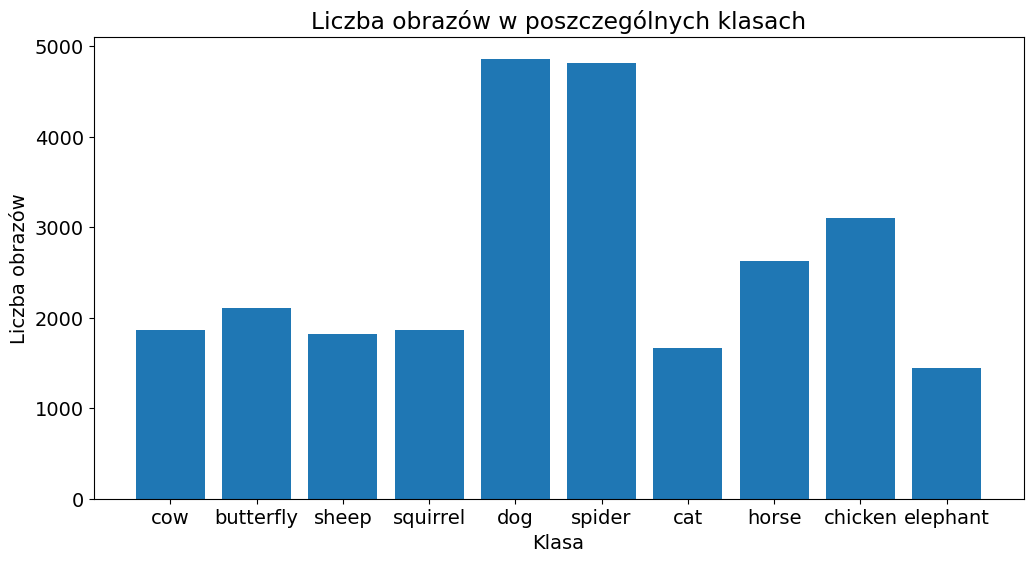

In [4]:
ROOT_DIR = "/content/Animals/images"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

# Ustaw mniejszy rozmiar wykresu (szerokość x wysokość)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(number_of_images.keys(), number_of_images.values())

ax.set_xlabel('Klasa')
ax.set_ylabel('Liczba obrazów')
ax.set_title('Liczba obrazów w poszczególnych klasach')

plt.style.use('ggplot')
plt.show()

oversampling, undersampling - imb learn
albo ważenie klas

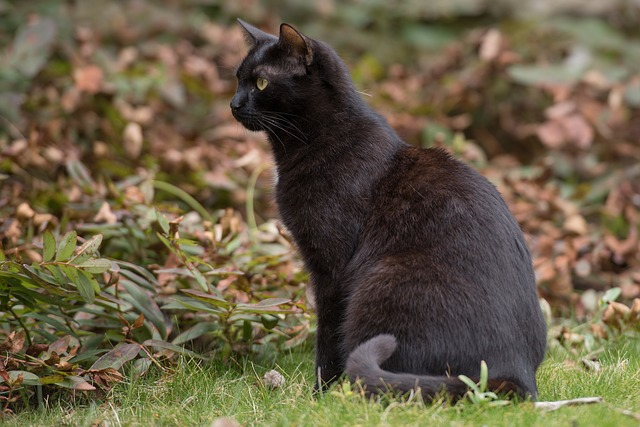

In [5]:
# Wyświetlenie przykładowego obrazu

data_dir='/content/Animals/images'
path_dir=pathlib.Path(data_dir)
sample_img=list(path_dir.glob('cat/*'))[5]
Image.open(sample_img)

In [6]:
img = Image.open(sample_img)
print(img.size)

(640, 427)


In [7]:
img_size = 32
batch_size = 64
directory = '/content/Animals/images'
num_classes = 10

traingen = ImageDataGenerator(rescale=1/255., validation_split=0.15)

train_dataset = traingen.flow_from_directory(directory,
                                             target_size=(img_size, img_size),
                                             batch_size=batch_size,
                                             shuffle=True,
                                             class_mode='categorical',
                                             subset='training')

val_dataset = traingen.flow_from_directory(directory,
                                           shuffle=False,
                                           batch_size=batch_size,
                                           target_size=(img_size, img_size),
                                           class_mode="categorical",
                                           subset='validation')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [8]:
class_labels = train_dataset.class_indices
print(class_labels)

{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [9]:
print("Liczba przykładów w zbiorze treningowym:", train_dataset.samples)
print("Liczba przykładów w zbiorze walidacyjnym:", val_dataset.samples)

Liczba przykładów w zbiorze treningowym: 22257
Liczba przykładów w zbiorze walidacyjnym: 3922


In [10]:
images, labels = train_dataset[0]
print("Shape of images batch:", images.shape)
print("Shape of labels batch:", labels.shape)

Shape of images batch: (64, 32, 32, 3)
Shape of labels batch: (64, 10)


# 3. Przygotowanie modelu

# 3.1 VGG transfer learning na zbiorze zbalansowanym batchami

In [30]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    base_model = tf.keras.applications.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(img_size, img_size, 3))

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    # Stworzenie nowego, który się będzie uczył
    last_output = base_model.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(128,activation="relu")(x)
    x = Dense(512,activation="relu")(x)
    outputs = Dense(10,activation="softmax")(x)
    model = Model(inputs=base_model.inputs,outputs=outputs)

    oversample = RandomOverSampler()

    auggen=ImageDataGenerator(zoom_range= 0.2,
                              horizontal_flip = True,
                              rotation_range = 45,
                              fill_mode='nearest',
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.6,
                              channel_shift_range=0.2
                              )


    class CustomModel(keras.Model):
        def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            x, y = data
            for i in range(len(y)):
              x_train.append(x[i])
              y_train.append(y[i])

            x_train = np.array(x_train)
            y_train = np.array(y_train)

            reshaped_x = x_train.reshape(x_train.shape[0],-1)

            oversampled_x_train, oversampled_y_train  = oversample.fit_resample(reshaped_x, y_train)
            oversampled_x_train = oversampled_x_train.reshape(-1,img_size,img_size,3)

            traindata=auggen.flow(oversampled_x_train, oversampled_y_train, batch_size=len(y))
            X, Y = next(traindata)


            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value
                # (the loss function is configured in `compile()`)
                loss = self.compute_loss(y=y, y_pred=y_pred)

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)
            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            # Update metrics (includes the metric that tracks the loss)
            for metric in self.metrics:
                if metric.name == "loss":
                    metric.update_state(loss)
                else:
                    metric.update_state(y, y_pred)
            # Return a dict mapping metric names to current value
            return {m.name: m.result() for m in self.metrics}

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [31]:
img_size = 32
batch_size = 64
optim_1 = Adam(learning_rate=0.0001)
# optim_1 = Adam(learning_rate=0.000005)
n_classes=10

n_steps = train_dataset.samples // batch_size
n_val_steps = val_dataset.samples // batch_size
n_epochs = 50
# n_epochs = 100

# Freeze dwóch ostatnich warstw
vgg_model = create_model(img_size, n_classes, optim_1, fine_tune=2)

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience = 10,
                                                 restore_best_weights=True,
                                                 mode='min')

# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [33]:
%%time

vgg_history = vgg_model.fit(train_dataset,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=val_dataset,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint, earlystopping],
                            verbose=1)

Epoch 1/50
347/347 [==============================] - ETA: 0s - loss: 1.9762 - accuracy: 0.3173
Epoch 1: val_loss improved from inf to 1.75426, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


347/347 [==============================] - 40s 110ms/step - loss: 1.9762 - accuracy: 0.3173 - val_loss: 1.7543 - val_accuracy: 0.4024
Epoch 2/50
347/347 [==============================] - ETA: 0s - loss: 1.6899 - accuracy: 0.4150
Epoch 2: val_loss improved from 1.75426 to 1.62778, saving model to model.h5
347/347 [==============================] - 33s 95ms/step - loss: 1.6899 - accuracy: 0.4150 - val_loss: 1.6278 - val_accuracy: 0.4365
Epoch 3/50
347/347 [==============================] - ETA: 0s - loss: 1.6036 - accuracy: 0.4422
Epoch 3: val_loss improved from 1.62778 to 1.55763, saving model to model.h5
347/347 [==============================] - 33s 96ms/step - loss: 1.6036 - accuracy: 0.4422 - val_loss: 1.5576 - val_accuracy: 0.4598
Epoch 4/50
201/347 [================>.............] - ETA: 15s - loss: 1.5480 - accuracy: 0.4631

KeyboardInterrupt: ignored

# 3.2 VGG od zera na zbiorze zbalansowanym batchami

In [40]:
# Czyli weights na None

# Define the model architecture
input_tensor = Input(shape=(img_size, img_size, 3))

# Set weights to None to train from scratch
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_tensor=input_tensor,
    input_shape=(img_size, img_size, 3),
    classes=10
)

# Add custom head to the model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

oversample = RandomOverSampler()

auggen=ImageDataGenerator(zoom_range= 0.2,
                           horizontal_flip = True,
                           rotation_range = 45,
                           fill_mode='nearest',
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.6,
                           channel_shift_range=0.2
                          )


class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        for i in range(len(y)):
          x_train.append(x[i])
          y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        reshaped_x = x_train.reshape(x_train.shape[0],-1)

        oversampled_x_train, oversampled_y_train  = oversample.fit_resample(reshaped_x, y_train)
        oversampled_x_train = oversampled_x_train.reshape(-1,img_size,img_size,3)

        traindata=auggen.flow(oversampled_x_train, oversampled_y_train, batch_size=len(y))
        X, Y = next(traindata)


        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y=y, y_pred=y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model.compile(optimizer=Adam(learning_rate=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

history = model.fit(train_dataset,epochs=100,validation_data=val_dataset, callbacks=[checkpoint,earlystopping])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/100
328/348 [===========================>..] - ETA: 1s - loss: 2.2321 - accuracy: 0.1875

KeyboardInterrupt: ignored

# 3.3 ResNet bez Transfer Learningu

In [ ]:
from tensorflow.keras.applications import ResNet50

# Przygotowanie modelu
model = tf.keras.applications.resnet50.ResNet50(weights=None, input_shape=(img_size, img_size, 3), classes=10)

oversample = RandomOverSampler()

auggen=ImageDataGenerator(zoom_range= 0.2,
                           horizontal_flip = True,
                           rotation_range = 45,
                           fill_mode='nearest',
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.6,
                           channel_shift_range=0.2
                          )


class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        for i in range(len(y)):
          x_train.append(x[i])
          y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        reshaped_x = x_train.reshape(x_train.shape[0],-1)

        oversampled_x_train, oversampled_y_train  = oversample.fit_resample(reshaped_x, y_train)
        oversampled_x_train = oversampled_x_train.reshape(-1,img_size,img_size,3)

        traindata=auggen.flow(oversampled_x_train, oversampled_y_train, batch_size=len(y))
        X, Y = next(traindata)


        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y=y, y_pred=y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

history = model.fit(train_dataset,epochs=100,validation_data=val_dataset, callbacks=[checkpoint,earlystopping])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




# 3.4 ResNet z Transfer Learningiem

In [ ]:
from tensorflow.keras.applications import ResNet50

# Przygotowanie modelu
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_shape=(img_size, img_size, 3), include_top = False)

base_model.trainable = False

# Stworzenie nowego, który się będzie uczył
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(128,activation="relu")(x)
x = Dense(512,activation="relu")(x)
outputs = Dense(10,activation="softmax")(x)
model = Model(inputs=base_model.inputs,outputs=outputs)

oversample = RandomOverSampler()

auggen=ImageDataGenerator(zoom_range= 0.2,
                           horizontal_flip = True,
                           rotation_range = 45,
                           fill_mode='nearest',
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.6,
                           channel_shift_range=0.2
                          )


class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        for i in range(len(y)):
          x_train.append(x[i])
          y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        reshaped_x = x_train.reshape(x_train.shape[0],-1)

        oversampled_x_train, oversampled_y_train  = oversample.fit_resample(reshaped_x, y_train)
        oversampled_x_train = oversampled_x_train.reshape(-1,img_size,img_size,3)

        traindata=auggen.flow(oversampled_x_train, oversampled_y_train, batch_size=len(y))
        X, Y = next(traindata)


        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y=y, y_pred=y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model.compile(optimizer=Adam(learning_rate=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

history = model.fit(train_dataset,epochs=100,validation_data=val_dataset, callbacks=[checkpoint,earlystopping])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [12]:
# VGG MAGDY

# Przygotowanie modelu
base_model = tf.keras.applications.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(img_size, img_size, 3))
base_model.trainable = False

# Stworzenie nowego, który się będzie uczył
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(128,activation="relu")(x)
x = Dense(512,activation="relu")(x)
outputs = Dense(10,activation="softmax")(x)
model = Model(inputs=base_model.inputs,outputs=outputs)

oversample = RandomOverSampler()

auggen=ImageDataGenerator(zoom_range= 0.2,
                           horizontal_flip = True,
                           rotation_range = 45,
                           fill_mode='nearest',
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.6,
                           channel_shift_range=0.2
                          )


class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        for i in range(len(y)):
          x_train.append(x[i])
          y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        reshaped_x = x_train.reshape(x_train.shape[0],-1)

        oversampled_x_train, oversampled_y_train  = oversample.fit_resample(reshaped_x, y_train)
        oversampled_x_train = oversampled_x_train.reshape(-1,img_size,img_size,3)

        traindata=auggen.flow(oversampled_x_train, oversampled_y_train, batch_size=len(y))
        X, Y = next(traindata)


        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compute_loss(y=y, y_pred=y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


model.compile(optimizer=Adam(learning_rate=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

history = model.fit(train_dataset,epochs=100,validation_data=val_dataset, callbacks=[checkpoint,earlystopping])


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Epoch 1/100
 28/348 [=>............................] - ETA: 33s - loss: 2.2630 - accuracy: 0.1802

KeyboardInterrupt: ignored